In [35]:
import Pkg; Pkg.activate(".."); Pkg.instantiate();

  Activating project at `c:\Users\matti\Documents\TUe\Thesis\ThesisParallelMP`


In [36]:
using RxInfer, Distributions, LinearAlgebra, Random, Plots, Parameters, ProgressMeter, StableRNGs

In [37]:
@show Threads.nthreads(), Threads.nthreads(:interactive)

(Threads.nthreads(), Threads.nthreads(:interactive)) = (8, 0)


(8, 0)

In [38]:
includet("../parallel.jl")

In [39]:
function generate_data(rng, n)
    return sin.(range(1, 4.0; length = n)) .+ 0.1 * rand(rng, n)
end

generate_data (generic function with 1 method)

In [40]:
struct NormalMeta
	size::Int
end

function factorial(n)
    if n == 0 || n == 1
        return 1
    else
        return factorial(n - 1) + factorial(n - 2)
    end
end

@rule NormalMeanVariance(:out, Marginalisation) (q_μ::Any, q_v::Any, meta::NormalMeta) = begin
    s = factorial(meta.size) / 10^8
    return @call_rule NormalMeanVariance(:out, Marginalisation) (q_μ = q_μ, q_v = PointMass(mean(q_v) + s))
end

@rule NormalMeanVariance(:μ, Marginalisation) (q_out::Any, q_v::Any, meta::NormalMeta) = begin
    s = factorial(meta.size) / 10^8
    return @call_rule NormalMeanVariance(:μ, Marginalisation) (q_out = q_out, q_v = PointMass(mean(q_v) + s))
end

@rule NormalMeanVariance(:out, Marginalisation) (m_μ::Any, q_v::Any, meta::NormalMeta) = begin
    s = factorial(meta.size) / 10^8
    return @call_rule NormalMeanVariance(:out, Marginalisation) (m_μ = m_μ, q_v = PointMass(mean(q_v) + s))
end

@rule NormalMeanVariance(:μ, Marginalisation) (m_out::Any, q_v::Any, meta::NormalMeta) = begin
    s = factorial(meta.size) / 10^8
    return @call_rule NormalMeanVariance(:μ, Marginalisation) (m_out = m_out, q_v = PointMass(mean(q_v) + s))
end

In [41]:
@model function state_space_model(n, size, prod_strategy, pipeline)
    # We create a sequence of random variables for hidden states
    x = randomvar(n) where { prod_strategy = prod_strategy }
    # As well a sequence of observartions
    y = datavar(Float64, n)

    meta = NormalMeta(size)

    x[1] ~ Normal(mean = 0.0, variance = 1.0) # where { pipeline = pipeline, meta = meta }
    y[1] ~ Normal(mean = x[1], variance = 1.0) # where { pipeline = pipeline, meta = meta }

    for i in 2:n
        x[i] ~ Normal(mean = x[i - 1], variance = 1.0) where { pipeline = pipeline, meta = meta }
        y[i] ~ Normal(mean = x[i], variance = 1.0) # where { pipeline = pipeline, meta = meta }
    end
end

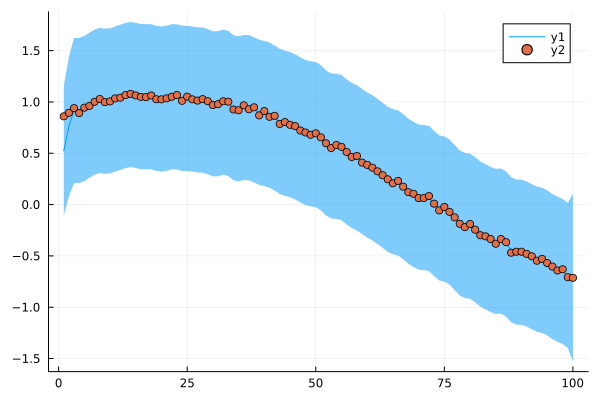

In [54]:
seed = 123
rng  = StableRNG(seed)
n = 100

data = generate_data(rng, n);

results = infer(
    model = state_space_model(n, 10, nothing, ThreadsReusingPipelineStage(vague(NormalMeanVariance))),
    data  = (y = data,),
    iterations    = 2,
    returnvars    = KeepLast(),
    options       = (limit_stack_depth = 100, ),
);
plot(mean.(results.posteriors[:x]), ribbon = std.(results.posteriors[:x]))
scatter!(data)

In [43]:
function execute_benchmark(f::F, n = 1000) where { F }

    # For the compilation
    f()

    GC.gc()
    GC.gc(true)

    times = Vector{Float64}(undef, n)

    for i in 1:n
        times[i] = f()
    end

    return times
end

execute_benchmark (generic function with 2 methods)

In [44]:
function benchmark_rule(size; n = 1000)
    times = Vector{Float64}(undef, n)

    m_out = NormalMeanVariance(0, 1)
    m_μ = NormalMeanVariance(0, 1)
    q_v = PointMass(1)
    meta = NormalMeta(size)

    x_rule = @call_rule NormalMeanVariance(:out, Marginalisation) (m_μ = m_μ, q_v = q_v, meta = meta)
    y_rule = @call_rule NormalMeanVariance(:μ, Marginalisation) (m_out = m_out, q_v = q_v, meta = meta)

    for i in 1:n
        start_time = time_ns()

        x_rule = @call_rule NormalMeanVariance(:out, Marginalisation) (m_μ = m_μ, q_v = q_v, meta = meta)
        y_rule = @call_rule NormalMeanVariance(:μ, Marginalisation) (m_out = m_out, q_v = q_v, meta = meta)

        times[i] = time_ns() - start_time
    end

    return times / 1000
end

benchmark_rule (generic function with 1 method)

In [63]:
function prepare_benchmark(prod, pipeline, size, n, niterations = 100)
    return () -> begin
        timing = Ref(0.0)
        current_iter = Ref(0.0)

        data = generate_data(rng, n)
        moptions = (limit_stack_depth = 300, )

        infer(
            model = state_space_model(n, size, prod, pipeline),
            data  = (y = data,),
            callbacks = (
                before_iteration = (model, iteration) -> begin
                    current_iter[] = time_ns()
                    return false
                end,
                after_iteration = (model, iteration) -> begin
                    current_iter[] = time_ns() - current_iter[]
                    timing[] = timing[] + current_iter[]
                    return false
                end
            ),
            iterations    = niterations,
            options       = moptions,
        )
        return timing[]
    end
end

prepare_benchmark (generic function with 3 methods)

In [62]:
function run_big_benchmark(combinations, orders, n; nsamples = 10, niterations = 100)
    return @showprogress map(orders) do order

        results = Dict()
        results[:rule] = benchmark_rule(order)

        for (key, combination) in combinations
            _b_combination = prepare_benchmark(combination[1], combination[2], order, n, niterations)
            results[key] = execute_benchmark(_b_combination, nsamples)
        end

        return (order, results)
    end
end

run_big_benchmark (generic function with 2 methods)

In [47]:
combinations = [
    :sequential => (nothing, nothing),
    :parallel_pipeline => (nothing, ThreadsPipelineStage()),
    :parallel_reusing => (nothing, ThreadsReusingPipelineStage(vague(NormalMeanVariance))),
]

3-element Vector{Pair{Symbol, Tuple{Nothing, Any}}}:
        :sequential => (nothing, nothing)
 :parallel_pipeline => (nothing, ThreadsPipelineStage())
  :parallel_reusing => (nothing, ThreadsReusingPipelineStage{NormalMeanVariance{Float64}}(NormalMeanVariance{Float64}(μ=0.0, v=1.0e12)))

In [60]:
function plot_benchmark(combinations, sizes, n, niterations)
    rule_results = run_big_benchmark(combinations, 10:2:25, n; niterations = 100);

    sizes = getindex.(rule_results, 1)
    benchmarks = getindex.(rule_results, 2)
    names = [first.(combinations); :rule]

    points = map(names) do name
        name => minimum.(getindex.(benchmarks, name))
    end |> Dict

    p = plot(
        xaxis = :log,
        yaxis = :log,
        legend = :bottomright,
        xlabel = "Rule time [μs]",
        ylabel = "Relative speed [-]",
        yticks = ([1:8;], [string(a) for a in 1:8]),
        ylim = (0.3, 8),
        gridalpha = 0.3,
        title = "N = $n",
    )

    for (key, values) in pairs(points)
        if key != :rule
            plot!(p, points[:rule], points[:sequential] ./ values, label = string(key))
        end
    end

    return p
end

plot_benchmark (generic function with 1 method)

In [64]:
sizes = 10:2:25
niterations = 100

p1 = plot_benchmark(combinations, sizes, 10, niterations)
p2 = plot_benchmark(combinations, sizes, 100, niterations)
p3 = plot_benchmark(combinations, sizes, 500, niterations);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
Progress: 100%|█████████████████████████████████████████| Time: 0:03:51
Progress: 100%|█████████████████████████████████████████| Time: 0:19:52


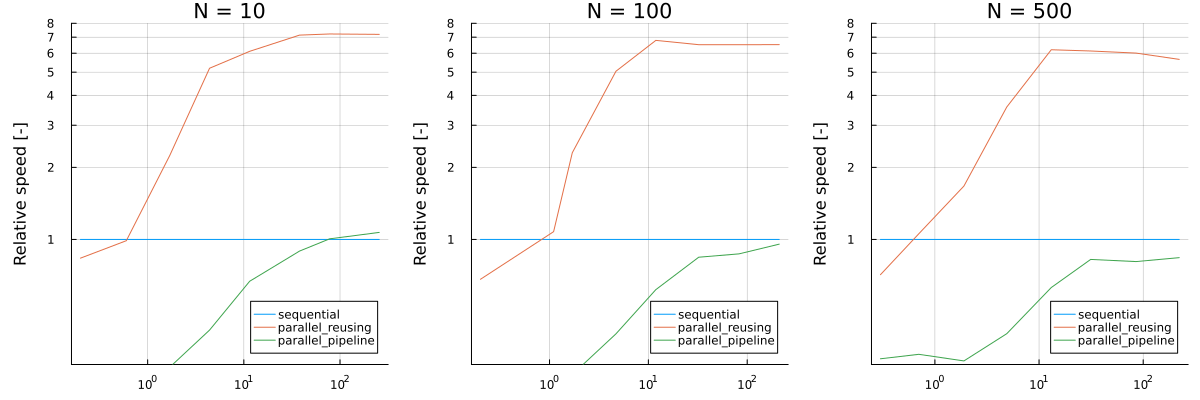

In [65]:
plot(p1, p2, p3, layout = (1, 3), size = (1200, 400), left_margin = 8Plots.mm)